<a href="https://colab.research.google.com/github/springboardmentor789r/AgriYield/blob/Intern_SaniyaMariyam/AgriYield_Predictor(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [6]:
# Upload your saved model
from google.colab import files
uploaded = files.upload()  # Upload 'catboost_crop_yield_model.pkl'

# Load from Pickle
import pickle
with open("catboost_crop_yield_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")


Saving catboost_crop_yield_model.pkl to catboost_crop_yield_model (3).pkl
Model loaded successfully.


In [9]:
from google.colab import files
uploaded = files.upload()

# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Load and clean dataset
df = pd.read_excel("crop_yield_dataset.xlsx")

# Detect target column (Crop Yield)
target_col = next((col for col in df.columns if "yield" in col.lower()), None)
if target_col is None:
    raise ValueError("Target column (Crop Yield) not found!")

# Drop missing and zero-yield rows
df = df.dropna()
df = df[df[target_col] != 0].reset_index(drop=True)
print(f"After cleaning → Shape: {df.shape}\n")

# Split into features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train Shape: {X_train.shape} | Test Shape: {X_test.shape}\n")

# Handle datetime columns (must match training preprocessing)
datetime_cols = X_test.select_dtypes(include=["datetime64"]).columns
if len(datetime_cols) > 0:
    print(f"Converting datetime columns: {list(datetime_cols)} to numeric features...\n")
    for col in datetime_cols:
        X_train[col] = pd.to_datetime(X_train[col])
        X_test[col] = pd.to_datetime(X_test[col])

        for part in ["year", "month", "day"]:
            X_train[f"{col}_{part}"] = getattr(X_train[col].dt, part)
            X_test[f"{col}_{part}"] = getattr(X_test[col].dt, part)

        X_train = X_train.drop(columns=[col])
        X_test = X_test.drop(columns=[col])

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical Columns used by CatBoost: {categorical_cols}\n")

# Generate predictions
y_pred_loaded = loaded_model.predict(X_test)
print(" Predictions generated successfully!\n")

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred_loaded)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_loaded))
r2 = r2_score(y_test, y_pred_loaded)

print("=== Loaded CatBoost Model Evaluation ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Saving crop_yield_dataset.xlsx to crop_yield_dataset (1).xlsx
After cleaning → Shape: (25495, 12)

Train Shape: (20396, 11) | Test Shape: (5099, 11)

Converting datetime columns: ['Date'] to numeric features...

Categorical Columns used by CatBoost: ['Crop_Type', 'Soil_Type']

 Predictions generated successfully!

=== Loaded CatBoost Model Evaluation ===
MAE  : 3.2180
RMSE : 4.5713
R²   : 0.9586


In [10]:
from google.colab import files
uploaded = files.upload()

# Install Prophet if not already installed
!pip install prophet --quiet

# Import required libraries
import pickle
from prophet import Prophet
import pandas as pd

# Load the saved Prophet model
with open("prophet_crop_yield_model.pkl", "rb") as f:
    loaded_prophet = pickle.load(f)

print("Prophet model loaded successfully!")


Saving prophet_crop_yield_model.pkl to prophet_crop_yield_model.pkl
Prophet model loaded successfully!


Saving time_series_analysis_dataset.xlsx to time_series_analysis_dataset.xlsx
=== Loaded Prophet Model Evaluation ===
MAE  : 4.7650
RMSE : 6.2270
R²   : 0.7378


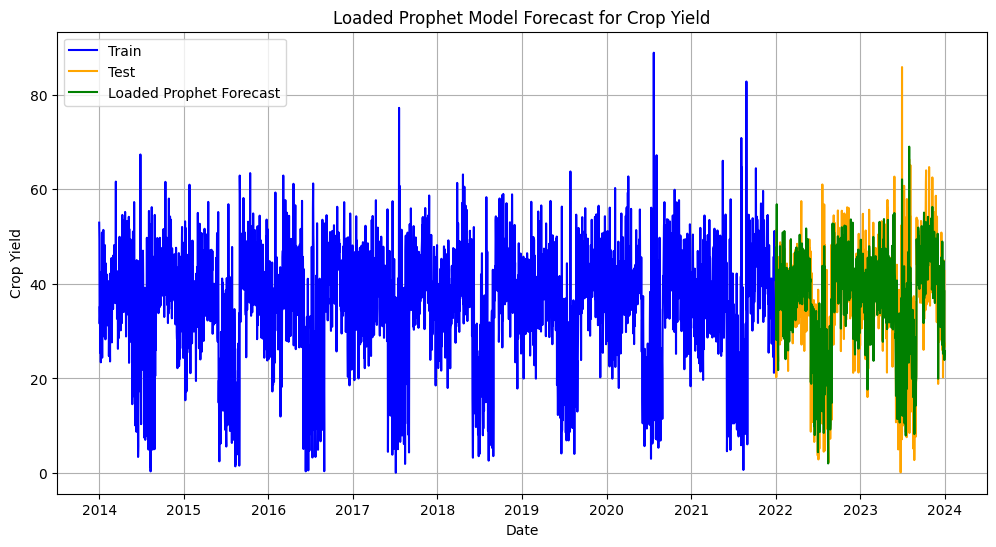

In [11]:
# Upload or load dataset
from google.colab import files
uploaded = files.upload()

# Load preprocessed dataset
df_daily = pd.read_excel("time_series_analysis_dataset.xlsx", index_col="Date", parse_dates=True)

# Prepare Prophet-compatible dataframe
df_exog = df_daily.copy().reset_index()
df_exog.rename(columns={"Date": "ds", "Crop_Yield": "y"}, inplace=True)

# Drop missing values
df_exog = df_exog.dropna(subset=["y"])

# Identify regressors (must match training ones)
exogenous_features = [col for col in df_exog.columns if col not in ["ds", "y"]]

# Split into train/test (80-20)
train_size = int(len(df_exog) * 0.8)
train_df = df_exog.iloc[:train_size].copy()
test_df = df_exog.iloc[train_size:].copy()

# Prepare future dataframe (train + test)
future = loaded_prophet.make_future_dataframe(periods=len(test_df))

# Add the same regressors
future[exogenous_features] = pd.concat([train_df[exogenous_features], test_df[exogenous_features]], axis=0).reset_index(drop=True)

forecast_loaded = loaded_prophet.predict(future)

# Extract the forecasted test range
forecast_test = forecast_loaded.iloc[-len(test_df):]

# Show results
forecast_test[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = test_df["y"].values
y_pred = forecast_test["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("=== Loaded Prophet Model Evaluation ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# Visualise results
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train_df["ds"], train_df["y"], label="Train", color='blue')
plt.plot(test_df["ds"], test_df["y"], label="Test", color='orange')
plt.plot(test_df["ds"], y_pred, label="Loaded Prophet Forecast", color='green')
plt.title("Loaded Prophet Model Forecast for Crop Yield")
plt.xlabel("Date")
plt.ylabel("Crop Yield")
plt.legend()
plt.grid(True)
plt.show()
